# MNIST Classification
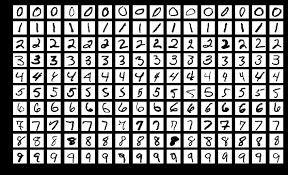

### The goal of this notebook is to explore the MNIST dataset and build high accuracy models

## Importing Stuff!

In [1]:
# Importing numpy and matplotlib
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Importing mnist and preparing train and test sets
from sklearn.datasets import fetch_openml

def get_mnist_sets():
    """Returns MNIST X_train, X_test, y_train, y_test sets."""
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # Target is initially type object
    X, y = mnist["data"], mnist["target"]
    X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]  # Mnist comes already ordered with train / test
    return X_train, y_train, X_test, y_test


# Let's get train and test sets!
X_train, y_train, X_test, y_test = get_mnist_sets()

## Exploring

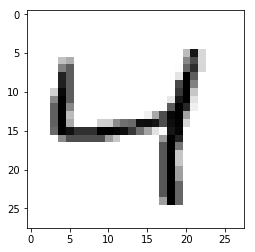

In [9]:
def show_digit(digit):
    digit_reshaped = digit.reshape(28,28)
    plt.imshow(digit_reshaped, cmap=mpl.cm.binary)
    plt.show()
show_digit(X_train[2])

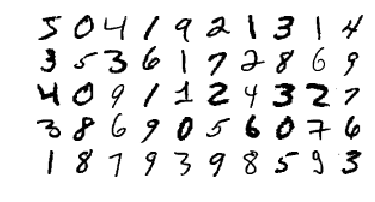

In [4]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

# Let's see the first 50 digits
plot_digits(X_train[:50])

# Building a simple Kneighbor classifier

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn_clf = KNeighborsClassifier(n_neighbors=4, n_jobs=-1, weights='distance')

knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [11]:
y_pred_knn = knn_clf.predict(X_test)
y_pred_knn[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int8)

In [25]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred_knn) # KNeighbors do pretty well!

0.9714

# Building a simple RandomForest classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf) 

/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9481

# Tuning the Random Forest Classifier

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [5, 10, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}
grid_search_rf = GridSearchCV(rf_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 18.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 50, 100, 200], 'criterion': ['gini', 'entropy'], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [38]:
grid_search_rf.best_score_

0.9713666666666667

In [42]:
y_pred = grid_search_rf.predict(X_test)
accuracy_score(y_test, y_pred) # That's a very nice classifier!

0.9741

# Augmenting Data

In [95]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

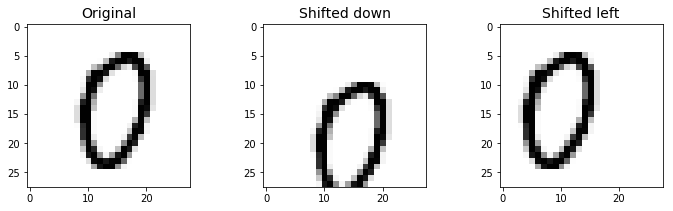

In [96]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [97]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [101]:
rf_clf = RandomForestClassifier(**grid_search_rf.best_params_)
rf_clf.fit(X_train_augmented, y_train_augmented)

y_pred = rf_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9825

# Analyzing Errors

In [52]:
from sklearn.metrics import confusion_matrix

conf_mx_rf = confusion_matrix(y_test, y_pred)
conf_mx_rf

array([[ 972,    0,    1,    0,    0,    2,    1,    1,    3,    0],
       [   0, 1124,    3,    2,    0,    2,    2,    1,    1,    0],
       [   6,    0, 1003,    4,    2,    0,    3,    8,    6,    0],
       [   0,    0,    8,  979,    0,    6,    0,    8,    7,    2],
       [   1,    0,    2,    0,  963,    0,    4,    0,    2,   10],
       [   3,    0,    0,    9,    3,  865,    5,    1,    5,    1],
       [   4,    3,    0,    0,    3,    4,  940,    0,    4,    0],
       [   1,    4,   16,    2,    0,    0,    0,  993,    2,   10],
       [   3,    0,    6,    6,    3,    6,    3,    4,  936,    7],
       [   4,    5,    2,   10,   10,    3,    1,    3,    5,  966]])

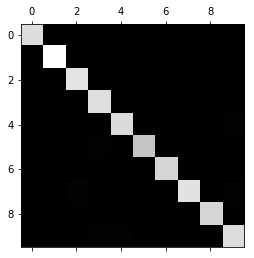

In [51]:
plt.matshow(conf_mx_rf, cmap=plt.cm.gray)

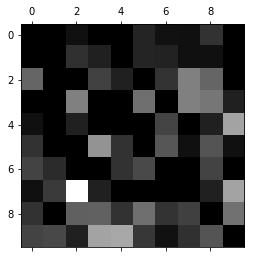

In [76]:
row_sums = conf_mx_rf.sum(axis=1)

norm_conf_mx_rf = conf_mx_rf /row_sums
np.fill_diagonal(norm_conf_mx_rf, 0)

plt.matshow(norm_conf_mx_rf, cmap=plt.cm.gray)

# The most common error is missclassifying 7 with 2

In [80]:
cl_a, cl_b = 2, 7

X_aa = X_test[(y_test == cl_a) & (y_pred == cl_a)]
X_ab = X_test[(y_test == cl_a) & (y_pred == cl_b)]
X_ba = X_test[(y_test == cl_b) & (y_pred == cl_a)]
X_bb = X_test[(y_test == cl_b) & (y_pred == cl_b)]

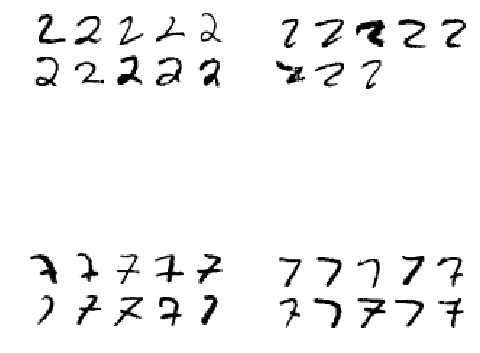

In [91]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:10], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:10], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:10], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:10], images_per_row=5)